In [48]:
import os,sys
sys.path.append('./misc/lib/python3.7/site-packages')

import numpy as np
import requests
import nglview as nv
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
import parmed as pmd
import re

import hublib.use
from hublib.ui import FileUpload, Download
from hublib.cmd import runCommand

%use gromacs-5.1.4

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)



def fix_missing_atoms(mdstruc, resnumber):
    for r in mdstruc.residues:
        if(r.number==resnumber):
            foundC = False
            foundO = False
            foundN = False
            foundCA = False
            for at in r:    
                if at.name=='C':
                    foundC = True
                elif at.name=='O':
                    foundO = True
                elif at.name=='N':
                    foundN = True
                elif at.name=='CA':
                    foundCA = True
                
            if foundC * foundN * foundO * foundCA:
                print('Replacing with GLY')
                mdstruc.strip('(:'+str(r.idx+1)+')&!(@C,CA,N,O)')
                mdstruc.residues[r.idx].name = 'GLY'
            else:
                print('Eliminating from the structure.')
                mdstruc.strip(':'+str(resnumber))
            break

def run_pdb2gmx(mdstruc, fname, lastPass):
    
    bondmax = 1.5*2
    
    success = True
    MissingAtomRegEx = re.compile('.*Residue(.*)named(.*)of a molecule in the input file was mapped to an entry in the topology database, but the atom(.*)used in that entry is not found in the input file')
    ResMisMatchRegEx = re.compile('.*Atom(.*)in residue[ ]+([a-zA-Z]+)[ ]+([0-9]+)[ ]+was not found in rtp entry(.*)with(.*)atoms while sorting atoms')
    ResNotFoundRegEx = re.compile('.*Residue(.*)not found in residue topology database')
    #out=!{"cd gmx; cp gmx/input.pdb.19 gmx/input.pdb; export GMX_MAXBACKUP=-1; gmx pdb2gmx -f input.pdb -o input.gro -ignh -water spce <<EOF\n8\nEOF"}
    out=!{"cd gmx; rm input.gro; export GMX_MAXBACKUP=-1; gmx pdb2gmx -f "+fname+" -o input.gro -ignh -water spce <<EOF\n8\nEOF"}
    msg = ''
    
    madeTop = False
    MadeTopRegEx = re.compile('You have successfully generated a topology')
    for line in out:
        if re.match(MadeTopRegEx, line):
            madeTop = True
    
    WarnNonSeqChain = re.compile('.*Chain identifier \'(.*)\' is used in two non-sequential blocks.*')
    WarnOccup = re.compile('.*there were (.*) atoms with zero occupancy and (.*) atoms.*')
    #WarnLongBond = re.compile('.*Long bond ((.*)-(.*) = (.*) nm).*')
    WarnLongBond = re.compile('.*Long Bond.*\(([0-9]+)-([0-9]+).*\).*')
    WarnAtomMissing = re.compile('.*atom (.*) is missing in residue ([a-zA-Z]+)[ ]+([0-9]+) in the pdb file.*')

    
    for line in out:
        if(success and re.search('warning', line, flags=re.IGNORECASE)):
            if re.match(WarnAtomMissing, line):
                hit = re.match(WarnAtomMissing, line)
                resname = hit.group(2).strip()
                resnumber = int(hit.group(3).strip())
                print('Atoms were missing from residue '+resname+ ' ' + str(resnumber))
                fix_missing_atoms(mdstruc, resnumber)
                mdstruc.write_pdb('gmx/'+fname)
                success = False
            elif re.match(WarnLongBond, line):
                if madeTop:
                    hit = re.match(WarnLongBond, line)
                    at1 = int(hit.group(1))
                    at2 = int(hit.group(2))
                    
                    grostruc = pmd.load_file('gmx/input.gro')
                    x1 = grostruc.coordinates[at1-1]
                    x2 = grostruc.coordinates[at2-1]
                    dist = np.linalg.norm(x1 - x2)
                    
                    # If this is an amide bond, and the distance is unreasonably large, insert a 
                    # chain break between the residues.
                    if (dist>bondmax) and (grostruc[at1-1].name=='C') and (grostruc[at1-1].name=='N'):
                        res1 = grostruc[at1-1].residue.number
                        res2 = grostruc[at2-1].residue.number
                        print('Bond between atoms ' + str(at1) + ' and ' + str(at2) + ' was too long (' + str(dist) +').')
                        print('Identified atoms as belonging to residues ' + str(res1) + ' and ' + str(res2))
                        print('Inserting chain break between them.')
                        if res1<res2:
                            grostruc[at1-1].residue.ter = True
                        else:
                            grostruc[at2-1].residue.ter = True
                        grostruc.write_pdb('gmx/'+fname)
                        success = False
            elif re.match(WarnNonSeqChain, line):
                if lastPass:
                    print('Non-sequential chain warning')
            elif re.match(WarnOccup, line):
                if lastPass:
                    print('Occupancy warning')
            else:
                if lastPass:
                    print(line)
                    print('We are here')
    
    if success: 
        for line in out:
            
            if re.search('error', line, flags=re.IGNORECASE) and (len(msg)==0):
                success = False
                msg = line
                
            elif len(msg)>0:
                if len(line.strip())>0:
                    msg = msg + line + " "
                else:
                    if re.match(MissingAtomRegEx, msg):
                        hit = re.match(MissingAtomRegEx, msg)
                        resnumber = int(hit.group(1))
                        resname = hit.group(2).strip()
                        print('Atoms were missing from residue '+resname+ ' ' + str(resnumber))
                        fix_missing_atoms(mdstruc, resnumber)
                        mdstruc.write_pdb('gmx/'+fname)

                    elif re.match(ResNotFoundRegEx, msg):
                        hit = re.match(ResNotFoundRegEx, msg)
                        resname = hit.group(1).strip().strip('\'')
                        print('Residue '+resname+ ' not available in the force field database.')
                        print('Eliminating from the structure.')
                        mdstruc.strip(':'+resname)
                        mdstruc.write_pdb('gmx/'+fname)

                    elif re.match(ResMisMatchRegEx, msg):
                        hit = re.match(ResMisMatchRegEx, msg)
                        resname = hit.group(2).strip()
                        resnum = int(hit.group(3).strip())
                        print('Residue ' +resname+ ' ' + str(resnum) + ' did not match the force field database entry.')
                        print('Eliminating from the structure.')
                        mdstruc.strip(":"+str(resnum))
                        mdstruc.write_pdb('gmx/'+fname)
                    else:
                        if lastPass:
                            print(msg)

                    msg = ''
    return success
    
def mdgo_onclick(b):
    
    
    chainList = list()
    for r in struc.residues:
        if chainList.count(r.chain)==0:
            chainList.extend(r.chain)
            
    # First identify which chains should be displayed
    chainList = []
    # Loop through chain-selection check-boxes
    for cb in accordion.children[0].children[1:]:
        if cb.value==True:
            chainList.extend(cb.description)
    
    failed = False
    for chain in chainList:
        fname = 'input_'+ chain + '.pdb'
        struc.write_pdb('gmx/'+fname)
        mdstruc = pmd.load_file('gmx/'+fname)
        print("")
        print("********************************************")
        print('Preparing chain ' + str(chain) + ' for MD...')
        print("")
        mdstruc[chain,:,:].write_pdb('gmx/'+fname)
        maxTries = 100
        tries = 0
        tryAgain = True
        while tryAgain:
            tries += 1
            mdstruc = pmd.load_file('gmx/'+fname)
            mdstruc.write_pdb('gmx/' + fname + '.' + str(tries))
            if(run_pdb2gmx(mdstruc, fname, False)):
                tryAgain = False
                run_pdb2gmx(mdstruc, fname, True)
                print('Success!')
                
            elif tries >= maxTries:
                tryAgain = False
                print('Failed to generate gmx input in ' + str(maxTries) + ' attempts')
                failed = True
        if failed:
            break

            

class ExcStruc:
    def __init__(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.chains = []
        self.ham = []
        self.dips = []
        self.cents = []
        self.struc = pmd.structure.Structure()
            
    def reset(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.chains = []
        self.ham = []
        self.dips = []
        self.cents = []
        self.struc = pmd.structure.Structure()
        
    def build_structure(self):
        coords = []
        for n in range(0, self.nres):
            cent = xstruc.cents[n,:]
            dip = xstruc.dips[n,:]
            vStart = cent - 1.25*dip
            vStop = cent + 1.25*dip
            
            Nats = 10
            for a in range(0, Nats+1):
                xyz = (a/Nats)*vStart + (1 - a/Nats)*vStop
                self.struc.add_atom(pmd.topologyobjects.Atom(name='N'), 'Dip', self.resnums[n], chain=self.chains[n])
                coords.append(xyz)
        if len(coords)>0:
            self.struc.coordinates = np.array(coords)
            

class NGLRepList:
    def __init__(self):
        self.component_id = ''
        self.params = []
        self.names = []
        self.reps = list()
        
    def reset(self):
        self.component_id = ''
        self.params = []
        self.names = []
        self.reps = list()
        
    def append(self, nrep):
        self.names.append(nrep.name)
        ptext = {"type": nrep.type, "params": {"color": nrep.color, "sele": nrep.selection, "opacity": str(nrep.opacity)}}
        self.params.append(ptext)
        self.reps.append(nrep)
        
class NGLRep:
    def __init__(self, name, rtype, sel, col, opac):
        self.name = name
        self.type = rtype
        self.selection = sel
        self.color = col
        self.opacity = opac

def check_atoms(RefAtNames, QuerAtNames):
    ismatch = True
    for atnm in RefAtNames:
        if(QuerAtNames.count(atnm)!=1):
            ismatch = False
    return ismatch

def find_porph(pmdstruc, xtruc):
    PORatList = list(['NA', 'NB', 'NC', 'ND'])
    for n in range(0, len(pmdstruc.residues)):
        r = pmdstruc.residues[n]
        nmlist = list()
        for at in r:
            nmlist.append(at.name)
        if(check_atoms(PORatList, nmlist)):
            if(nmlist.count('MG')==1):
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('CHL')
                
            else:
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('PHO')
            xstruc.chains.append(r.chain)

    return


def find_dipoles(struc,xtruc):
    ResNums = xtruc.resnums
    DipMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        for at in r:
            if at.name=='NB':
                NB = struc.coordinates[at.idx]
            if at.name=='ND':
                ND = struc.coordinates[at.idx]
        DipMat[n,:] = NB - ND
    xtruc.dips = DipMat

def find_centers(struc, xtruc):
    ResNums = xtruc.resnums
    CentMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        cent = 0.0
        for at in r:
            if at.name=='NB':
                cent += 0.5*struc.coordinates[at.idx]
            if at.name=='ND':
                cent += 0.5*struc.coordinates[at.idx]
        CentMat[n,:] = cent
    xtruc.cents = CentMat

def sync_widgets_to_rep(rep):
    seldrop.value = rep.name
    styledrop.value = rep.type
    colordrop.value = rep.color
    opacslide.value = int(rep.opacity*100)
    
def sync_rep_to_widgets():
    global repList
    num = repList.names.index(seldrop.value)
    rep = repList.reps[num]
    rep.type = styledrop.value
    rep.name = seldrop.value
    rep.color = colordrop.value
    rep.opacity = opacslide.value*0.01
    ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
    repList.params[num] = ptext
    pdbview.set_representations(repList.params)
    

def std_rep(nglview, struc, xstruc):
    global repList
    pdbview.add_trajectory(struc)
    pdbview.clear(0)
    chltxt = ''
    photxt = ''
    for n in range(0, len(xstruc.resnums)):
        if xstruc.restypes[n]=='CHL':
            if len(chltxt)>0:
                chltxt += ' or '
            chltxt += str(xstruc.resnums[n]+1)
        if xstruc.restypes[n]=='PHO':
            if len(photxt)>0:
                photxt += ' or '
            photxt += str(xstruc.resnums[n]+1)
            
    chainList = list()
    chainString = ''
    for r in struc.residues:
        if chainList.count(r.chain)==0:
            chainList.extend(r.chain)
            if len(chainString)>0:
                chainString += " OR "
            chainString += ":" + r.chain
    
    repList.append(NGLRep("Protein", "cartoon", "(protein)" + "AND (" + chainString + ")", "grey", 0.2))
    if len(chltxt)>0:
        repList.append(NGLRep("Chlorophyll", "licorice", "(" + chltxt + ")" + "AND (" + chainString + ")", "green", 1.0))
    if len(photxt)>0:
        repList.append(NGLRep("Pheophytin", "licorice", "(" + photxt + ")" + "AND (" + chainString + ")", "blue", 1.0))
    
    pdbview.set_representations(repList.params)
    
    seldrop.options=repList.names
    seldrop.disabled=False
    
    styledrop.disabled=False
    
    colordrop.disabled=False
    opacslide.disabled=False
    sync_widgets_to_rep(repList.reps[0])
    
    if xstruc.nres>0:
        pdbview.add_trajectory(xstruc.struc)
        pdbview.set_representations([{"type": "licorice", "params": {"color": "red", "sele": "("+chainString+")", "opacity": "1", "radius": "0.35"}}], component=1)
    
pdbid = widgets.Text(
    value='3EOJ',
    placeholder='Type something',
    layout = widgets.Layout(width='2.5cm'),
    disabled=False
)

pdbidtxt = widgets.Label(value='Enter PDB ID:', width='4cm')

pdbgo = widgets.Button(
    description='Fetch',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to display the pdb file',
    layout = widgets.Layout(width='2cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
)

pdbup = hublib.ui.FileUpload("", "Upload a PDB file for display and processing", basic=True, width='2cm')

pdboutput = widgets.HTML(
    value="",
    placeholder='',
    description='',
)

Output = widgets.Output()

# pdbwrite = widgets.Button(
#     description='Write PDB',
#     disabled=True,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     tooltip='Click to write selected components to PDB file',
#     icon='' # (FontAwesome names without the `fa-` prefix)
# )



def clear_stage(view, xstruc):

    view._clear_component_auto_completion()
    if view._trajlist:
        for traj in view._trajlist:
            view._trajlist.remove(traj)
    for component_id in view._ngl_component_ids:
        component_index = view._ngl_component_ids.index(component_id)
        view._ngl_component_ids.remove(component_id)
        view._ngl_component_names.pop(component_index)
        view._remote_call('removeComponent',
            target='Stage',
            args=[component_index,])
    view._update_component_auto_completion()


def pdbup_onclick(widg, fname):
    load_structure(fname[-1])
    widg.reset()
        
def pdbgo_onclick(b):
    fname = 'pdb/' + pdbid.value + '.pdb'
    load_structure(fname)
    
def load_structure(fname):
    global struc
    global estruc
    
    if os.path.isfile(fname):
        fid = fname.split('/')[-1]
        fid = fid.split('.')[0]
        pdbid.value=fid
        
    else:
        url = 'http://files.rcsb.org/download/'+pdbid.value+'.pdb'
        r = requests.get(url, allow_redirects=True)
        if(r.status_code==200):
            fname = 'pdb/'+pdbid.value+'.pdb'
            wfd = open(fname, 'wb')
            wfd.write(r.content)
            wfd.close()
            pdboutput.value = ''
            
        else:
            print('Invalid PDB code. Please try again.')
            
    
        
    if os.path.isfile(fname):
        #clear_stage(pdbview, xstruc)
        while len(pdbview._ngl_component_ids)>0:
            pdbview.remove_component(pdbview._ngl_component_ids[0])
        
        accordion.children = []
        repList.reset()
        xstruc.reset()
        
        struc = pmd.load_file(fname)
        find_porph(struc, xstruc)
        find_dipoles(struc, xstruc)
        find_centers(struc, xstruc)
        xstruc.build_structure()
        std_rep(pdbview, struc, xstruc)
        chainList = list()
        chainString = ''
        for r in struc.residues:
            if chainList.count(r.chain)==0:
                chainList.extend(r.chain)
                chainString += r.chain
                
        chwidgList = [widgets.HBox([widgets.Button(description='All',tooltip='Click to select all chains', layout = widgets.Layout(width='1.5cm')),
                    widgets.Button(description='None',tooltip='Click to deselect all chains',layout = widgets.Layout(width='1.5cm'),)])]
        
        chwidgList[0].children[0].on_click(select_all_chains)
        chwidgList[0].children[1].on_click(deselect_all_chains)
        
        for chain in chainList:
            chwidgList.append(widgets.Checkbox(description=chain, value=True,indent=False))
            chwidgList[-1].observe(chain_box_on_change)
        accordion.children = [widgets.VBox(chwidgList)]
        
        deffnm = pdbid.value + '_' + chainString + '.pdb'
        pdbwrwidglist = [widgets.HBox([widgets.Text(value=deffnm, description='File Name:', disabled=False, layout=widgets.Layout(width='5cm')),widgets.Button(description='Write',tooltip='Click to write PDB file',layout=widgets.Layout(width='1.5cm'),)])]
        pdbwrwidglist[0].children[1].on_click(pdbwrite_onclick)
        
        accordion.children = tuple(list(accordion.children) + [widgets.VBox(pdbwrwidglist)])
        
        mdgo = widgets.Button(
            description='Prepare MD',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to prepare structure for molecular dynamics (MD)',
            icon='' # (FontAwesome names without the `fa-` prefix)
        )

        mdgolist = [widgets.HBox([mdgo])]
        accordion.children = tuple(list(accordion.children) + [widgets.VBox(mdgolist)])
        accordion.children[2].children[0].children[0].on_click(mdgo_onclick)
        

    else:
        pdboutput.value = 'Please enter a valide PDB ID code.'

def select_all_chains(b):
    for cb in accordion.children[0].children[1:]:
        cb.value = True
        
def deselect_all_chains(b):
    for cb in accordion.children[0].children[1:]:
        cb.value = False
        
        
def chain_box_on_change(b):
    global repList
    if b['type'] == 'change' and b['name'] == 'value':
        
        # First identify which chains should be displayed
        chainString = ''
        chainList = []
        chainChars = ''
        # Loop through chain-selection check-boxes
        for cb in accordion.children[0].children[1:]:
            if cb.value==True:
                chainList.extend(cb.description)
                if len(chainString)>0:
                    chainString += " OR "
                chainString += ":" + cb.description
                chainChars += cb.description
                
        for num in range(0, len(repList.reps)):
            rep = repList.reps[num]
            selList = rep.selection.split('AND')
            selText = ''
            for item in selList:
                if item.find(":")==-1:
                    if len(selText)>0:
                        selText += " AND "
                    selText += item.strip()
            
            if len(chainString)>0:
                selText += " AND (" + chainString + ")"
            else:
                # We assume no structure has chain ID XXXX...
                selText += " AND (:XXXX)"
                
            rep.selection = selText
            ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
            repList.params[num] = ptext
        pdbview.set_representations(repList.params)
        
        if len(chainString)>0:
            pdbview.set_representations([{"type": "licorice", "params": {"color": "red", "sele": "("+chainString+")", "opacity": "1", "radius": "0.35"}}], component=1)
            accordion.children[1].children[0].children[0].value = pdbid.value + "_" + chainChars + '.pdb'
            accordion.children[1].children[0].children[1].disabled = False
            accordion.children[2].children[0].children[0].disabled = False
        else:
            pdbview.set_representations([{"type": "licorice", "params": {"color": "red", "sele": "(:XXXX)", "opacity": "1", "radius": "0.35"}}], component=1)
            accordion.children[1].children[0].children[0].value = ''
            accordion.children[1].children[0].children[1].disabled = True
            accordion.children[2].children[0].children[0].disabled = True
            
                
    
def seldrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        rep = repList.reps[repList.names.index(seldrop.value)]
        sync_widgets_to_rep(rep)
        
def styledrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = repList.names.index(seldrop.value)
        rep = repList.reps[num]
        rep.type = styledrop.value
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        repList.params[num] = ptext
        pdbview.set_representations(repList.params)
        
def colordrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = repList.names.index(seldrop.value)
        rep = repList.reps[num]
        rep.color = colordrop.value
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        repList.params[num] = ptext
        pdbview.set_representations(repList.params)
        
def opacslide_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = repList.names.index(seldrop.value)
        rep = repList.reps[num]
        rep.opacity = opacslide.value*0.01
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        repList.params[num] = ptext
        pdbview.set_representations(repList.params)

xstruc = ExcStruc()
pdbgo.on_click(pdbgo_onclick)
pdbup.cb = pdbup_onclick
pdbid.on_submit(pdbgo_onclick)
pdbview = nv.NGLWidget()
pdbview._set_size('500px', '500px')
repList = NGLRepList()

seldrop = widgets.Dropdown(
    options=repList.names,
    #value='Protein',
    description='Selection:',
    disabled=True,
)

styledrop = widgets.Dropdown(
    options=['cartoon', 'licorice', 'spacefill'],
    description='Style:',
    disabled=True,
)

colordrop = widgets.Dropdown(
    options=['chain', 'red', 'green', 'blue', 'grey'],
    description='Color:',
    disabled=True,
)

opacslide = widgets.IntSlider(
    min=0,
    max=100,
    step=1,
    description='Opacity:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

from ipywidgets import Layout
accordion = widgets.Accordion(children=[])
accordion.set_title(0, 'Chain Selection')
accordion.set_title(1, 'Write PDB')
accordion.set_title(2, 'Prepare for MD')

#pdbuptext = widgets.Label(value="Or upload a file:", layout=widgets.Layout(width='3.5cm', display="flex", justify_content='flex-end'))

pdbbox = widgets.HBox([pdbidtxt, pdbid, pdbgo])
dispbox = widgets.VBox([seldrop, styledrop, colordrop, opacslide, accordion])
viewbox = widgets.HBox([pdbview, dispbox])

seldrop.observe(seldrop_on_change)
styledrop.observe(styledrop_on_change)
colordrop.observe(colordrop_on_change)
opacslide.observe(opacslide_on_change)

display(pdbbox)
display(pdbup)
display(pdboutput)
display(viewbox)
struc = pmd.structure.Structure()

    
def pdbwrite_onclick(b):
    fname = "pdb/" + accordion.children[1].children[0].children[0].value
    # First identify which chains should be displayed
    # Loop through chain-selection check-boxes
    strucList = []
    for cb in accordion.children[0].children[1:]:
        if cb.value==True:
            strucList.append(struc[cb.description,:,:])
    
    selstruc = []
    if len(strucList)>0:
        selstruc = strucList[0]
        for n in range(1, len(strucList)):
            selstruc = selstruc + strucList[n]
        selstruc.write_pdb(fname)
        

HTML(value='', placeholder='')

In [6]:
#Coupling Matrix based on Dipoles
N = len(xstruc.cents) #size of coupling matrix based on number of dipoles
V = np.zeros((N,N)) #coupling matrix

for m in range (0, N):
    for n in range (0, m):
        mu1 = xstruc.dips[m]/np.linalg.norm(xstruc.dips[m])
        mu2 = xstruc.dips[n]/np.linalg.norm(xstruc.dips[n])
        Rmn = (xstruc.cents[m]-xstruc.cents[n])*(1e-1)
        rmn = np.linalg.norm(Rmn)
        Rmnhat=Rmn/rmn
        V[m,n] =5.04*0.9*(((4.8)**2)*(np.dot(mu1,mu2))-3*(np.dot(mu1,Rmnhat))*(np.dot(mu2,Rmnhat)))/(rmn**3)
        
#V[np.isnan(V)] = 0  #I was recieving values 'nan' on diagonals    
#V=np.nan_to_num(V) #I was recieving values 'nan' on diagonals
#print(V)
print(np.transpose(V)[:-1,1:])
V = V + np.transpose(V)


[[ 93.864  -9.897 -11.216]
 [  0.    -11.378 -10.249]
 [  0.      0.     92.028]]


In [7]:
print(V)

[[  0.     93.864  -9.897 -11.216]
 [ 93.864   0.    -11.378 -10.249]
 [ -9.897 -11.378   0.     92.028]
 [-11.216 -10.249  92.028   0.   ]]


In [14]:
for resnum in xstruc.resnums:
    print("***************************")
    tstruc = struc[':'+str(resnum+1)]
    AtNames = ['MG', 'CHA', 'CHB', 'CHC', 'CHD', 'NA', 'C1A', 'C2A', 'C3A', 'C4A', 'CMA', 'CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'NB', 'C1B', 'C2B', 'C3B', 'C4B', 'CMB', 'CAB', 'CBB', 'NC', 'C1C', 'C2C', 'C3C', 'C4C', 'CMC', 'CAC', 'CBC', 'ND', 'C1D', 'C2D', 'C3D', 'C4D', 'CMD', 'CAD', 'OBD', 'CBD', 'CGD', 'O1D', 'O2D', 'CED', 'C1']
    #AtNames = ['MG', 'NA', 'NB', 'NC', 'ND', 'K']
    for name in AtNames:
        atstruc = tstruc['@'+name]
        if len(atstruc.coordinates)>0:
            print('Atom ' + name + ' of Chl ' + str(resnum) + ' has these coordinates:')
            print("     " + str(atstruc.coordinates[0]))
            print("")
        else:  
            print("Error! Chl " + str(resnum) + ' was incomplete.')
            print("Could not find atom with name " + name)

***************************
Atom MG of Chl 451 has these coordinates:
     [-53.455 -56.228 205.7  ]

Atom CHA of Chl 451 has these coordinates:
     [-51.162 -56.009 208.323]

Atom CHB of Chl 451 has these coordinates:
     [-52.372 -53.119 204.629]

Atom CHC of Chl 451 has these coordinates:
     [-55.341 -56.613 202.708]

Atom CHD of Chl 451 has these coordinates:
     [-53.963 -59.682 206.368]

Atom NA of Chl 451 has these coordinates:
     [-52.099 -54.713 206.402]

Atom C1A of Chl 451 has these coordinates:
     [-51.304 -54.832 207.418]

Atom C2A of Chl 451 has these coordinates:
     [-50.366 -53.658 207.614]

Atom C3A of Chl 451 has these coordinates:
     [-50.878 -52.674 206.571]

Atom C4A of Chl 451 has these coordinates:
     [-51.86  -53.534 205.805]

Atom CMA of Chl 451 has these coordinates:
     [-51.508 -51.466 207.248]

Atom CAA of Chl 451 has these coordinates:
     [-48.891 -54.065 207.446]

Atom CBA of Chl 451 has these coordinates:
     [-48.552 -54.913 206.224]


Atom NA of Chl 455 has these coordinates:
     [-48.64  -53.116 180.177]

Atom C1A of Chl 455 has these coordinates:
     [-49.405 -53.84  179.429]

Atom C2A of Chl 455 has these coordinates:
     [-48.906 -53.954 178.025]

Atom C3A of Chl 455 has these coordinates:
     [-47.609 -53.147 178.054]

Atom C4A of Chl 455 has these coordinates:
     [-47.637 -52.608 179.442]

Atom CMA of Chl 455 has these coordinates:
     [-46.415 -54.038 177.834]

Atom CAA of Chl 455 has these coordinates:
     [-49.931 -53.497 176.965]

Atom CBA of Chl 455 has these coordinates:
     [-50.354 -52.032 177.003]

Atom CGA of Chl 455 has these coordinates:
     [-51.267 -51.65  178.129]

Atom O1A of Chl 455 has these coordinates:
     [-52.417 -52.064 178.24 ]

Atom O2A of Chl 455 has these coordinates:
     [-50.792 -50.754 179.159]

Atom NB of Chl 455 has these coordinates:
     [-47.097 -51.537 182.246]

Atom C1B of Chl 455 has these coordinates:
     [-46.482 -51.104 181.165]

Atom C2B of Chl 455 has the

Atom CBD of Chl 458 has these coordinates:
     [-39.215 -67.633 180.137]

Atom CGD of Chl 458 has these coordinates:
     [-40.318 -67.405 179.122]

Atom O1D of Chl 458 has these coordinates:
     [-40.648 -66.255 178.746]

Atom O2D of Chl 458 has these coordinates:
     [-41.298 -68.47  179.002]

Atom CED of Chl 458 has these coordinates:
     [-42.565 -68.115 178.389]

Atom C1 of Chl 458 has these coordinates:
     [-36.196 -71.587 185.001]

***************************
Atom MG of Chl 459 has these coordinates:
     [-47.501 -69.722 188.809]

Atom CHA of Chl 459 has these coordinates:
     [-48.925 -66.951 190.748]

Atom CHB of Chl 459 has these coordinates:
     [-45.321 -70.121 191.379]

Atom CHC of Chl 459 has these coordinates:
     [-45.565 -71.716 186.713]

Atom CHD of Chl 459 has these coordinates:
     [-49.423 -68.717 186.057]

Atom NA of Chl 459 has these coordinates:
     [-47.118 -68.655 190.778]

Atom C1A of Chl 459 has these coordinates:
     [-47.791 -67.725 191.349]




Atom C3B of Chl 461 has these coordinates:
     [-39.775 -75.294 190.977]

Atom C4B of Chl 461 has these coordinates:
     [-39.144 -75.576 189.649]

Atom CMB of Chl 461 has these coordinates:
     [-41.971 -76.27  192.116]

Atom CAB of Chl 461 has these coordinates:
     [-39.234 -74.356 192.002]

Atom CBB of Chl 461 has these coordinates:
     [-40.051 -73.783 192.893]

Atom NC of Chl 461 has these coordinates:
     [-37.506 -75.844 187.106]

Atom C1C of Chl 461 has these coordinates:
     [-37.106 -75.051 188.107]

Atom C2C of Chl 461 has these coordinates:
     [-35.811 -74.389 187.905]

Atom C3C of Chl 461 has these coordinates:
     [-35.41  -74.879 186.581]

Atom C4C of Chl 461 has these coordinates:
     [-36.532 -75.79  186.187]

Atom CMC of Chl 461 has these coordinates:
     [-35.127 -73.444 188.87 ]

Atom CAC of Chl 461 has these coordinates:
     [-34.152 -74.595 185.814]

Atom CBC of Chl 461 has these coordinates:
     [-33.072 -75.492 186.416]

Atom ND of Chl 461 has th

In [51]:
#Coupling Matrix with TrESP

Natoms = 46
NChl = len(xstruc.cents)
AtomPos = np.zeros((NChl, Natoms, 3))
AtomQ = np.zeros((NChl, Natoms, 1))
C = np.zeros((NChl,NChl))
h = 6.62607015e-34 #J*s
c = 2.998e10 #cm/s

for n in range(0,len(xstruc.resnums)):
    resnum = xstruc.resnums[n]
    tstruc = struc[':'+str(resnum+1)]
    AtNames = ['MG', 'CHA', 'CHB', 'CHC', 'CHD', 'NA', 'C1A', 'C2A', 'C3A', 'C4A', 'CMA', 'CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'NB', 'C1B', 'C2B', 'C3B', 'C4B', 'CMB', 'CAB', 'CBB', 'NC', 'C1C', 'C2C', 'C3C', 'C4C', 'CMC', 'CAC', 'CBC', 'ND', 'C1D', 'C2D', 'C3D', 'C4D', 'CMD', 'CAD', 'OBD', 'CBD', 'CGD', 'O1D', 'O2D', 'CED', 'C1']
    Q10 = np.array([-21.674,106.779,-48.696,-98.725,72.726,31.683,-130.820,10.048,2.389,77.983,5.556,-1.050,0.735,-8.040,-1.330,7.091,-62.297,81.122,4.777,-9.204,106.271,16.963,10.681,34.947,-12.166,83.646,-7.420,-1.126,-44.008,-5.161,8.020,1.012,108.292,-110.812,-11.981,8.799,-125.044,-25.156,-19.250,-20.044,-11.238,5.979,-5.388,1.811,-5.256,-1.424])
    Q10 = Q10*1e-3*4.80326e-10 # cgs base units for charge: cm^3/2 g^1/2 s^−1
    dip = np.zeros((3,))
    for at in range(0,len(AtNames)):
        name = AtNames[at] #AtNames is a matrix with all the atoms name; (at)th name on the matrix 
        atstruc = tstruc['@'+name]
        if len(atstruc.coordinates)>0:
            AtomPos[n, at, :] = (atstruc.coordinates[0])*(1e-8) # cm
            AtomQ[n,at] = Q10[at] # cm^3/2 g^1/2 s^−1
            dip += AtomPos[n,at,:]*AtomQ[n,at]
        else:
            print("Error! Chl " + str(resnum) + ' was incomplete.')
            print("Could not find atom with name " + name)
    if np.linalg.norm(dip)>0:
        print(np.linalg.norm(dip))
        AtomQ[n,:] *= (4.3e-18)/np.linalg.norm(dip)
            
#Partial charge potentials from SI information
#list1 = [-20.742,171.473,-52.285,-177.983,54.880,49.179,-176.145,14.161,-0.023,93.117,3.686,-0.723,0.563,-8.486,-1.273,7.964,-86.872,96.238,17.126,-27.569,181.543,21.362,8.694,25.870,-60.172,184.094,-27.645,12.196,-31.390,-1.921,12.949,2.318,144.929,-136.481,-12.055,-5.037,-197.159,-30.178,3.730,-22.673,-26.107,4.964,-4.611,2.960,-4.956,-1.510]
#qA = np.array(list1)*1.0e-3 #put q in cgs units

for m in range (0,NChl):
    for n in range(0,m):
        for atm in range (0, Natoms): 
            for atn in range(0,Natoms):
                Rmn = AtomPos[m,atm,:]-AtomPos[n,atn,:] 
                rmn = np.linalg.norm(Rmn) 
                C[m,n]+= (((AtomQ[m,atm]*AtomQ[n,atn])/(rmn))*(1e-7))/(h*c)

C = C + np.transpose(C)

print(np.round(C))

5.727099556856101e-18
5.73666884366408e-18
5.717326992480375e-18
5.698405433828939e-18
[[ 0. 86.  6. 26.]
 [86.  0. 26.  7.]
 [ 6. 26.  0. 90.]
 [26.  7. 90.  0.]]


In [47]:
Reppert_CP47_C = np.array([
    [0, -42, 0, 0, -3, 0, 1, 2, -1, 2, -1, 1, 0, -1, -3, 0],
    [0, 0, -89, 19, 5, -7, -5, 6, -20, -14, -4, 6, -9, -2, 4, -2],
    [0, 0, 0, 3, -3, -58, -2, -8, 30, 16, 2, -9, 4, -2, -1, -4],
    [0, 0, 0, 0, -43, -13, 62, 5, -10, -5, -2, 18, -31, 7, -3, 0],
    [0, 0, 0, 0, 0, 66, -18, -2, 0, -4, -4, -5, -7, -4, 12, 10],
    [0, 0, 0, 0, 0, 0, 6, -3, 7, -4, 5, -4, 9, 4, 1, 8],
    [0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 5, -1, 15, 4, -2, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, -15, -87, -15, 19, -6, -3, 3, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 8, -13, 9, 3, -2, 5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -12, 51, -2, -6, 34, -7],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -12, 58, 33, -16, 7],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -62, 88, 21, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -61, -3, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -12, 12],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

Reppert_CP47_C += np.transpose(Reppert_CP47_C)

print(np.max(np.abs(Reppert_CP47_C - C)))


0.49831585048245275


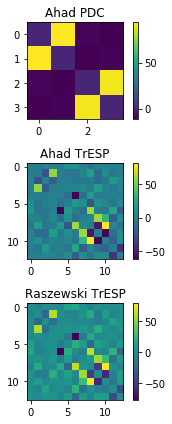

-62.306007998405704
-76


In [38]:
RengerC = [[0, -7, 0, -2, -3, 12, 16, 1, -9, 3, -2, 0, 1],
[0, 0, -25, 60, 1, -6, -8, 3, 19, -12, 10, -6, -1],
[0, 0, 0, -20, -2, 0, -5, -3, -4, -11, -4, 13, 4],
[0, 0, 0, 0, 2, 4, 2, 6, -2, 21, 3, -3, 4],
[0, 0, 0, 0, 0, -13, -76, -11, 18, -2, -1, 1, -4],
[0, 0, 0, 0, 0, 0, 20, 10, -25, 11, 4, -6, 9],
[0, 0, 0, 0, 0, 0, 0, -10, 64, -3, -6, 24, -24],
[0, 0, 0, 0, 0, 0, 0, 0, 6, 56, 29, -16, 9],
[0, 0, 0, 0, 0, 0, 0, 0, 0, -50, 78, 3, -8],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -59, -9, 10],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -15, 9],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -41],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
RengerC = np.array(RengerC)
RengerC = RengerC + np.transpose(RengerC)

Cscale = (C).astype(int)

plt.figure(figsize=(3,6))

plt.subplot(3,1,1)
plt.imshow(V)
plt.title('Ahad PDC')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(Cscale)
plt.colorbar()
plt.title('Ahad TrESP')

plt.subplot(3,1,3)
plt.imshow(RengerC)
plt.colorbar()
plt.title('Raszewski TrESP')

plt.tight_layout()
plt.show()



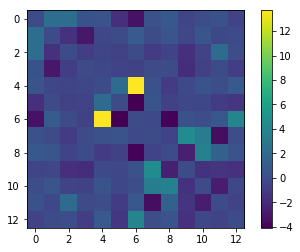

-62.306007998405704
-76


In [39]:

#plt.imshow(C/np.max(np.abs(C)) - RengerC/np.max(np.abs(RengerC)))
plt.imshow(C - RengerC)
plt.colorbar()
plt.show()

np.max(np.abs(C))/np.mean(np.max(RengerC))
print(C[4,6])
print(RengerC[4,6])


In [38]:
# Set up the frequency axis
v1 = 16000
v2 = 18000
dv = 1
vaxis = np.arange(v1,v2,dv)
spec = np.zeros(np.shape(vaxis))

# Generate a random ensemble of site energies, diagonalize, and add results to spectrum
eVals,eVecs = np.linalg.eigh(C)
eMu = np.matmul(np.transpose(eVecs), xstruc.dips)

for n in range(0,NChl):
    ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
    spec[ndx] += eMu[n]**2/NChl

# Plot the spectrum
plt.figure()
plt.plot(vaxis, spec)
plt.title('Absorption Spectrum')

ValueError: setting an array element with a sequence.

(1,)


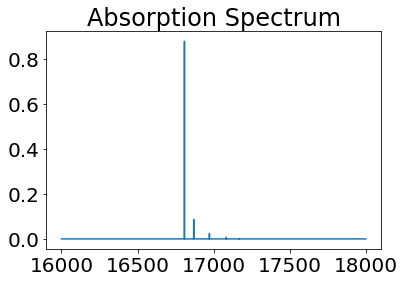

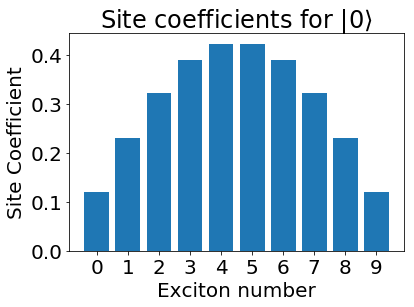

In [31]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
plt.rcParams.update({'font.size': 20})
np.set_printoptions(suppress=True, precision=3)

# Set parameters -- all frequencies/energies are in 1/cm
vo = 17000              # Site energy -- identical for all sites
V = -100                # Coupling constant
Nosc = 10               # Number of oscillators
Mu = np.ones((Nosc,1))  # Dipole moment matrix


# Build the Hamiltonian matrix -- we use frequency in 1/cm
H = np.zeros((Nosc,Nosc))
for n in range(0, Nosc-1):
    H[n,n+1] = V
H = H + np.transpose(H)
H = H + np.eye(Nosc)*vo

# Set up the frequency axis
v1 = 16000
v2 = 18000
dv = 1
vaxis = np.arange(v1,v2,dv)
spec = np.zeros(np.shape(vaxis))

# Generate a random ensemble of site energies, diagonalize, and add results to spectrum
eVals,eVecs = np.linalg.eig(H)
eMu = np.matmul(np.transpose(eVecs), Mu)

for n in range(0,Nosc):
    ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
    spec[ndx] += eMu[n]**2/Nosc

# Plot the spectrum
plt.figure()
plt.plot(vaxis, spec)
plt.title('Absorption Spectrum')

# Plot the site coefficients for the lowest-energy eigenstate
plt.figure()
plt.bar(np.arange(0,Nosc), eVecs[:,0])
plt.title('Site coefficients for $|0 \\rangle$')
plt.xticks(range(0,Nosc))
plt.xlabel('Exciton number')
plt.ylabel('Site Coefficient')
plt.show()

In [19]:
#Calculate R
R = []
for n in range(0,len(xstruc.cents)):
    R1=[]
    for m in range(0, len(xstruc.cents)):
        vec = np.subtract(xstruc.cents[m], xstruc.cents[n])
        ans = np.linalg.norm(vec)
        R1.append(ans) 
    R.append(R1)
print(R)

[[0.0, 9.936760739798457, 21.212142896228094, 19.338429563953742], [9.936760739798457, 0.0, 19.257920325154533, 20.96116566415141], [21.212142896228094, 19.257920325154533, 0.0, 9.977075936866472], [19.338429563953742, 20.96116566415141, 9.977075936866472, 0.0]]


In [ ]:
r = np.power(R, 3)
print(r)

In [ ]:
#Calculate Dot Product
Mu = []
for n in range(0,len(xstruc.cents)):
    Mu1=[]
    for m in range(0, len(xstruc.cents)):
        dot = np.sum(xstruc.dips[m]*xstruc.dips[n])
        Mu1.append(dot)
    Mu.append(Mu1)
print(Mu)

In [ ]:
#Calculate R hat
Rh = []
for n in range(0,len(xstruc.cents)):
    Rh1=[]
    for m in range(0, len(xstruc.cents)):
        vect = np.subtract(xstruc.cents[m], xstruc.cents[n])
        ???
        Rh1.append(vect)
    Rh.append(Rh1)
print(Rh)

In [ ]:
answ =[]
y = []
    y([n,m]) = Rh([n,m])/R([n,m])
answ.append(y)


In [ ]:
#Calculate R hat
R2 = []
for n in range(0,len(xstruc.cents)):
    R3=[]
    answ = []
    for m in range(0, len(xstruc.cents)):
        vect = np.subtract(xstruc.cents[m], xstruc.cents[n])
        R3.append(vect)
    R2.append(R3)
    #answ = R2[n,m]/R[n,m] #how do i make matrix divide R2(1,3) by R(1,3)?
    
print(R2)

In [ ]:
#Upload Button
def done_cb(w, name):
    print("%s uploaded" % name)
    w.reset()
    
f = ui.FileUpload("Protein Data Bank file", 
               "PDB File Upload",
               dir='tmpdir',
               cb=done_cb,
               maxsize='100M')

#Run All Below Button
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(f)
display(button)

<IPython.core.display.Javascript object>

In [ ]:
Prfile=f.list()
Prfiletext=Prfile[0]
        
#ParsePDB

#Matrix for ND atom coordinates
search=open(Prfiletext,'r').readlines()
NDMatrix=[]
for line in search:
    if re.match("(HETATM)(.*ND)", line):
        y = line.split()
        if len(y)==11:
            ChlID=str(y[3])+str(y[4])
            x_coord=float(y[5])
            y_coord=float(y[6])
            z_coord=float(y[7])
            Chl_atom=y[10]
        if len(y)==10:
            ChlID=str(y[3])
            x_coord=float(y[4])
            y_coord=float(y[5])
            z_coord=float(y[6])
            Chl_atom=y[9]
        coord=[x_coord, y_coord, z_coord]
        NDMatrix.append(coord)
        print(NDMatrix)
    
#Matrix for NB atom coordinates
search=open(Prfiletext,'r').readlines()
NBMatrix=[]
for line in search:
    if re.match("(HETATM)(.*NB)", line):
        y = line.split()
        if len(y)==11:
            ChlID=str(y[3])+str(y[4])
            x_coord=float(y[5])
            y_coord=float(y[6])
            z_coord=float(y[7])
            Chl_atom=y[10]
        if len(y)==10:
            ChlID=str(y[3])
            x_coord=float(y[4])
            y_coord=float(y[5])
            z_coord=float(y[6])
            Chl_atom=y[9]
        coord=[x_coord, y_coord, z_coord]
        NBMatrix.append(coord)
        print(NBMatrix)

In [ ]:
#Calculate Dipole
D = np.subtract(NDMatrix, NBMatrix)
print(D)

In [ ]:
R = []
for n in range(0,len(D)):
    R1=[]
    for m in range(0, len(D)):
        ans = np.sqrt(np.sum(np.square(np.subtract(D[n],D[m]))))
        R1.append(ans)
    R.append(R1)
print(R)


In [ ]:
V=np.zeros(len(D),len(D))
print(V)

In [ ]:
ND=np.transpose(NDMatrix)
z = np.dot(NBMatrix,ND)
print(z)

In [33]:
np.array([-21.674,106.779,-48.696,-98.725,72.726,31.683,-130.820,10.048,2.389,77.983,5.556,-1.050,0.735,-8.040,-1.330,7.091,-62.297,81.122,4.777,-9.204,106.271,16.963,10.681,34.947,-12.166,83.646,-7.420,-1.126,-44.008,-5.161,8.020,1.012,108.292,-110.812,-11.981,8.799,-125.044,-25.156,-19.250,-20.044,-11.238,5.979,-5.388,1.811,-5.256,-1.424])

array([ -21.674,  106.779,  -48.696,  -98.725,   72.726,   31.683,
       -130.82 ,   10.048,    2.389,   77.983,    5.556,   -1.05 ,
          0.735,   -8.04 ,   -1.33 ,    7.091,  -62.297,   81.122,
          4.777,   -9.204,  106.271,   16.963,   10.681,   34.947,
        -12.166,   83.646,   -7.42 ,   -1.126,  -44.008,   -5.161,
          8.02 ,    1.012,  108.292, -110.812,  -11.981,    8.799,
       -125.044,  -25.156,  -19.25 ,  -20.044,  -11.238,    5.979,
         -5.388,    1.811,   -5.256,   -1.424])